# Exercise X03.1 - Dynamic Mode Decomposition (DMD)
Reproduce the results presented of learning dynamics of Fluid flow past cylinder using a flowmap based on DMD. 

(i) Construct the DMD and visualize the first few eigenvectors of the full system matrix A. (ii) Perform a flowmap to time step 200 from the initial step 0. Evaluate how errors develop in time up to time step 150 were data is available for different choices of the truncation parameter r. 

Make sure to describe how the model is produced and visualize the results.

In [1]:
import scipy.io
import numpy as np

### Load data

The data from the DMD book is loaded and the relevant parameters are stored as variables. $X_{original}$ is the original data while $n$ and $m$ are the size of the dimensions of the data. See Exercise 1.7 for plots of the raw data.

In [2]:
cylinder_data = scipy.io.loadmat("../DATA/CYLINDER_ALL.mat")

m = cylinder_data['m'].squeeze()
n = cylinder_data['n'].squeeze()
X_original = cylinder_data['VORTALL']

# (i)

The function below is an implements DMD in 4 steps as explained in the book ( pages 262-263 Second Edition ). These steps can be summarised as follow:

1) Compute the SVD of the first time-shifted matrix: $X\sim \tilde{U} \Sigma \tilde{V}^*$.
2) Chose a truncation rank $r$ and compute the truncated version of the best fit linear operator: $\tilde{A} = \tilde{U}X'\tilde{V}\tilde{\Sigma}^{-1}$.
3) Compute the spectral decomposition of $\tilde{A}$, i.e. $\tilde{A}W = W\Lambda$.
4) Use DMD to resume the high dimensional eigenstates of $A$, $\Phi = X'\tilde{V}\tilde{\Sigma}^{-1}W$.

Once $\Phi$ is known, it is possible to recover the modes amplitudes as $b = (W\Lambda)^{-1} \tilde{x}_1$. Note that the rank $r$ for the truncation (step 2) is chosen accordingly the hard-thrashold algorithm from Ganish and Dunoho described here [The Optimal Hard Threshold ofr Singular values](https://gitlab.windenergy.dtu.dk/scientific-machine-learning-speical-course/sml-exercises-report/-/blob/master/Exercise%20X03.1/The_Optimal_Hard_Threshold_for_Singular_Values.pdf).

In [3]:
def hard_threshold_for_singular_value( Sigma , m , n ):
    
    # Implementation of the hard-threshold algorithm.
    ymed = np.median( Sigma ) 
    beta = n / m
    omega = 0.56 * beta ** 3 - 0.95 * beta ** 2 + 1.82 * beta + 1.43   
    threshold = ymed * omega
    r = len( Sigma[ Sigma > threshold ] )
    print(f"Hard threshold rank r = {r}.")
    return r
    
def DMD( X , Xprime , rank = 0 ):
    
    # step1 + hard thresholding.
    U , Sigma , VT = np.linalg.svd( X , full_matrices = 0 ) 
    if rank == 0 :
        r = hard_threshold_for_singular_value( Sigma , X.shape[0] , X.shape[1] )
    else:
        r = rank
    Ur = U[ : , :r ]
    Sigmar = np.diag( Sigma[ :r ] )
    VTr = VT[ :r , : ]
    
    # step 2.
    Atilde = np.linalg.solve( Sigmar.T , ( Ur.T @ Xprime @ VTr.T ).T ).T
    
    # step 3.
    Lambda, W = np.linalg.eig( Atilde ) 
    Lambda = np.diag( Lambda )
    
    # step 4 + recover b.
    Phi = Xprime @ np.linalg.solve( Sigmar.T , VTr ).T @ W 
    alpha1 = Sigmar @ VTr[ : , 0 ]
    b = np.linalg.solve( W @ Lambda , alpha1 )
    
    return Phi, Lambda, b, W, Ur

To apply the DMD the data is separated in two sets, which differ of a single time step. After performing the DMD the eigenmodes are sorted based on the real part of the eigenvalues.

In [4]:
# Define X and X' as subset of the original datset.
X = X_original[:, :-1]
Xprime = X_original[:, 1:]

# Apply DMD.
Phi, Lambda, b, W, Ur = DMD( X , Xprime )

# Sort the eigenmodes.
sorted_idx = np.flip( np.argsort( np.real( np.diag( Lambda ) ) ) )
Phi_sorted = Phi[ : , sorted_idx ]
Lambda_sorted = Lambda[ sorted_idx , sorted_idx ]
b_sorted = b[ sorted_idx ]

Hard threshold rank r = 43.


The first six eigenmodes are plotted below.

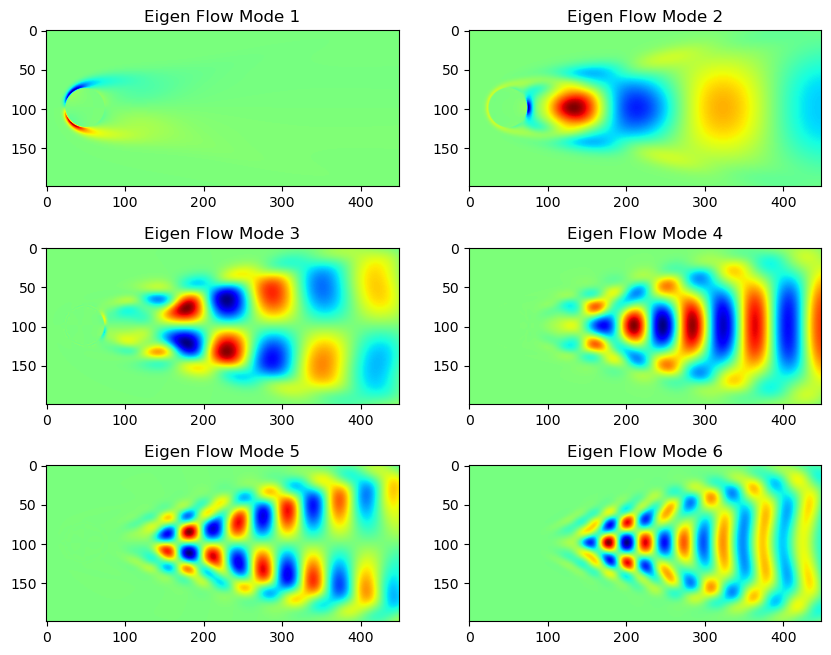

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
for r, ax in enumerate(axes.ravel()):
    eigen_vector_r = np.real(Phi_sorted[:, r*2]) # note multiplied by 2 due to modes in pairs
    ax.imshow(eigen_vector_r.reshape(n, m, order='C').T, cmap='jet')
    ax.set_title(f"Eigen Flow Mode {r+1}")

# (ii)

It is impractical to work with the full matrix $A$ since it requires too large memory resources. 
Instead it is possible to timestep in the frequency space (latent space) in order of predicting with much smaller matrices. This is demonstrated with the timings below.

First this is timed using $\Phi$, which is large and therefore should be slow c.f. the book page 240.

In [6]:
%%timeit
b1 = np.linalg.pinv( Phi ) @ X[ : , 0 ]
x1 = Phi @ Lambda @ b1

355 ms ± 59.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is then verfied against the smaller and supposedly faster version predicting in the spectral space (latent space).

In [7]:
%%timeit
x_tilde_1 = W @ Lambda @ b
b1 = np.linalg.inv(W @ Lambda) @ x_tilde_1
x1 = Phi @ b1

1.1 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
W = W[ sorted_idx , : ][ : , sorted_idx ]
Ur = Ur[ : , sorted_idx ]

Perform a flowmap to time step 200 from the initial step 0 for different choices of the truncation parameter $r$ and plot the results. 

In [9]:
rs = [ 7 , 8 , 15 , 30 , 43 ]
T = 200
X_DMD = np.zeros( ( X.shape[0] , len( rs ) , T ) )
X_DMD_error = np.zeros( ( X.shape[0] , len( rs ) , T ) )

for i , r in enumerate( rs ):
    Phi, Lambda, b, W, Ur = DMD( X , Xprime , rank = r )

    x1 = Phi @ Lambda @ b
    X_DMD[ : , i , 0 ] = np.real( x1 )
    b1 = b
    for t in range( T - 1 ):
        b1 = np.linalg.pinv( Phi ) @ x1
        x1 = Phi @ Lambda @ b1
        
        X_DMD[ : , i , t ] = np.real( x1 )
        if t < X.shape[ 1 ] - 1 :
            X_DMD_error[ : , i , t ] = X_DMD[:, i, t] - np.real( X[ : , t + 1 ] )

In [10]:
X_test = np.zeros(X_DMD.shape)
for i in range(X_test.shape[1]):
    X_test[:, i, :X_original.shape[1]] = X_original

In [11]:
# this code was used to produce the video below

# from matplotlib.animation import FuncAnimation
# import matplotlib as mpl
# mpl.rcParams["figure.facecolor"] = "white"
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# total_frames = T - 1

# # First set up the figure, the axis, and the plot element we want to animate.
# fig, axes = plt.subplots( 5 , 3 , figsize = ( 8 , 11 ) , sharey = True )

# plt.tight_layout()
# images = []
# labels = ['Original', 'DMD', 'Error']
# zz = [X_test, X_DMD, X_DMD_error]

# for y, label, z in zip( range( axes.shape[ 1 ] ) , labels , zz ):
#     pos = []
#     for x in range( axes.shape[0] ):
#         p = axes[ x , y ].imshow( z[ : , x , 0 ].reshape( ( n , m ) , order = 'C' ).T , cmap = 'jet' )
#         axes[x, y].set_title(f"{label}: r = {rs[x]}")
#         pos.append(p)
#     images.append(pos)

# # animation function.  This is called sequentially
# def animate(i, zz):
#     for idx_im, (image, z) in enumerate(zip(images, zz)):
#         for idx_pos, pos in enumerate(image):
#             pos.set_array(z[:, idx_pos, i].reshape((n, m), order='C').T)
#             images[idx_im][idx_pos] = pos
#     return images

# anim = FuncAnimation(fig, lambda i: animate(i, zz), frames=total_frames, interval=T/10)

# video_name = 'DMD_vort.mp4'
# anim.save(video_name, fps=20, extra_args=['-vcodec', 'libx264'])
# plt.close()

Link to the video: [Dynamic Mode Decomposition, cylinder flow](https://youtube.com/shorts/8DsKWGZNuk4?feature=share)

While the error is visible in the plot below it is hard to evaluate the difference between the ranks.
Therefore a relative root mean square error is calulcated for each of the ranks.

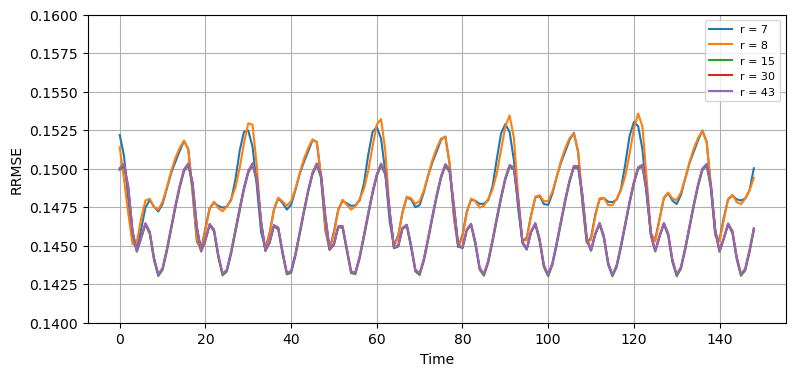

In [12]:
fig = plt.figure(figsize=(9, 4))
ax = plt.gca()
for r, error_r in zip( rs , np.split( X_DMD_error , X_DMD_error.shape[1] , axis = 1 )):
    RMSE = np.sqrt(np.mean(error_r[:, 0, :X.shape[1]-1]**2, axis=0))
    RRMSE = RMSE/np.sqrt(np.mean(np.real(X[:, 1:])**2, axis=0))
    plt.plot( RRMSE , label=f"r = {r}")
plt.legend(loc="upper right",fontsize=8)
ax.grid()
ax.set_ylim((0.14,0.16))
ax.set_xlabel("Time")
ax.set_ylabel("RRMSE")
plt.show()

Looking at the plot above, we observe that the errors show a periodic behaviour. While the periods does not vary much some differences are presents at peaks and valeys, this could be due to numerical noise in the original data but is not further inverstigated.
The plot shows that a a rank of $r=15$ is nearly indistiguisable from both $r=30$ and $r=43$, this is an interestng finding as the hard threshold alghorhitm indicated the need for additional modes. This could be because the hard threshold is optimal for the ASME not RRMSE, other explanations could be investigated but is considered outside the scope.

Overall, the plots shows that the method seems sound for this problem, which makes sense considering the peridic nature of the problem.

## Additional final consideration.

Before implementing the Optimal Hard Threshold method, we tried the same exercise with different ranks $r=21$, obtaining the plot below.
This plot was added because there was interesitng observation in it between $r=10$ and $r=21$.

It can be seen that they are performing close to the same level, however as time passes $r=10$ is diverging slightly.
This means that should the DMD model be used to extrapolate it is expected that the error will increase over time.
Here it would probably be prefered to use the higher rank model over the low rank one and sacrifice the accuracy in the beggining and go with a sustained accuracy.

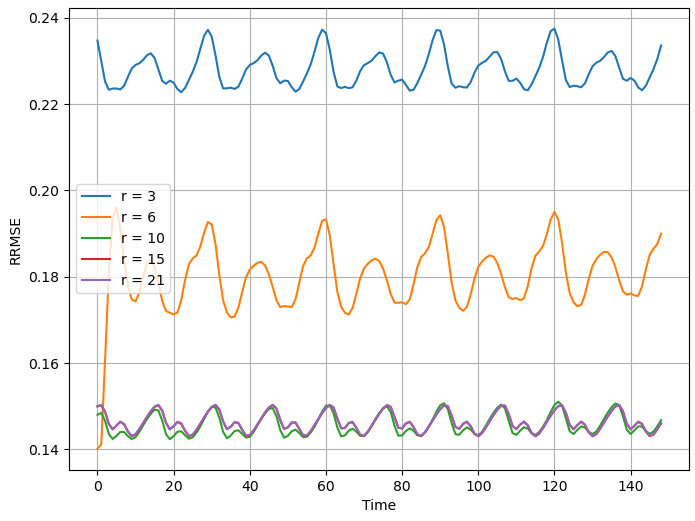

In [13]:
from IPython import display
display.Image("./Img/DMD_rank_21.png", embed = True)